In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fuzzywuzzy as fuzz
from fuzzywuzzy import process

c:\Users\macdk\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Load the data CSVs

In [2]:
# Load full_output.csv
df = pd.read_csv('csv_files/full_output.csv')
df.columns = df.columns.str.strip()

# Drop Event and TEA column
df = df.drop(columns=['Event', 'TEA'])
print(len(df))

# Load pml_output.csv
pml_df = pd.read_csv('csv_files/pml_output.csv')
pml_df.columns = pml_df.columns.str.strip()

60669


# Remove disqualified and null rows

In [3]:
# Remove DNA, DQ
judging_columns = ['Stage Judge 1', 'Stage Judge 2', 'Stage Judge 3', 'Stage Final', 'SR Judge 1', 'SR Judge 2', 'SR Judge 3', 'SR Final']

for i in judging_columns:
    df = df[df[i] != 'DNA']
    df = df[df[i] != 'DQ']

# Convert blanks to nans
for i in judging_columns:
    df[i] = df[i].replace(['', ' '], np.nan)

print(len(df))

60141


In [4]:
# Trim whitespace, double spaces, commas, and periods from selections
selection_columns = ['Selection 1', 'Selection 2', 'Selection 3']

for i in selection_columns:
    df[i] = df[i].str.strip()
    df[i] = df[i].str.replace('  ', ' ', regex=False)
    df[i] = df[i].str.replace(',', '', regex=False)
    df[i] = df[i].str.replace('.', '', regex=False)

# Trim whitespace from classification column
df['Classification'] = df['Classification'].str.strip()

# Remove composer/arranger information from selections
for column in selection_columns:
    # remove all inside parenthesis
    df[column] = df[column].str.replace('\(.*\)', '', regex=True)
    # trim whitespace
    df[column] = df[column].str.strip()


## Get the average judge rating

In [5]:
# Average together Stage Judge 1, 2, and 3 into a new column
for i in judging_columns:
    df[i] = df[i].astype(float)

df['Stage Average'] = (df['Stage Judge 1'] + df['Stage Judge 2'] + df['Stage Judge 3']) / 3

## Export clean csv

In [6]:
# Export df to csv
df.to_csv('csv_files/full_output_clean.csv', index=False)

# Functions for analysis

In [7]:
year_list = df['Year'].unique()
class_list = df['Classification'].unique()
conf_list = df['Conference'].unique()

df['Conference'] = df['Conference'].replace('2C', 'CC')
df['Conference'] = df['Conference'].replace('4A', 'AAAA')
df['Conference'] = df['Conference'].replace('cc', 'CC')
df['Conference'] = df['Conference'].replace('1C', 'C')

print(year_list)
print(class_list)
print(conf_list)


[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022]
['Varsity' 'Sub Non-Varsity' 'Sub Non-Varsity A' 'Sub Non-Varsity B'
 'Non-Varsity B' 'Non-Varsity C' 'Non-Varsity E' 'Non-Varsity F'
 'Sub Non-Varsity C' 'Sub Non-Varsity D' 'Sub Non-Varsity E' 'Non-Varsity'
 'Non-Varsity A' nan 'Combined' 'Non-Varsity D' 'Var-Composite'
 'Var-Combined' '' 'NVar-Composite' 'NVar-Combined' 'Sub Non-Varsity F'
 'Varsity C' 'Varsity B' 'Varsity A' 'Sub Non-Varsity G' 'Var-Composite A'
 'Sub Non-Varsity H' 'Sub Non-Varsity I' 'NVar-Composite A']
['CC' 'AAAAA' 'AAAA' 'C' 'CCC' 'AAA' 'A' 'AA' 'BBB' 'BB' 'Varsity '
 'Non-Varsity ' 'Non-Varsity A' 'Sub Non-Varsity ' 'Sub Non-Varsity B' 'B'
 'Var-Composite ' '2C' ' Acc:n/a' '4A' 'cc' ' Acc:N/A' 'Non-Varsity C'
 'Var-Combined ' 'NVar-Composite ' '1C' 'AAAAAA']


In [8]:
def top_n_grabber(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]

    # Select each Selection into a list
    selection_1_list = df_grabber['Selection 1'].tolist()
    selection_2_list = df_grabber['Selection 2'].tolist()
    selection_3_list = df_grabber['Selection 3'].tolist()
    # combine selection 1, 2, and 3 into one dataframe
    full_selection_list = pd.DataFrame(selection_1_list + selection_2_list + selection_3_list)

    top_n_df = pd.DataFrame(full_selection_list.value_counts()[:n])
    top_n_df.columns = ['Count']
    top_n_df.reset_index(drop=False, inplace=True)
    top_n_df.columns = ['Selection', 'Count']
    top_n_df

    # make selection column into a list
    selection_list = top_n_df['Selection'].tolist()
    value_list = top_n_df['Count'].tolist()
    return selection_list, value_list

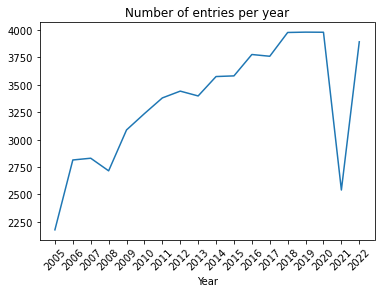

In [9]:
# Plot a line graph of the number of rows in each year
df_year_counter = df.groupby('Year').size()
df_year_counter.plot(kind='line')
plt.xticks(year_list)
plt.xticks(rotation=45)
plt.title('Number of entries per year')
plt.show()

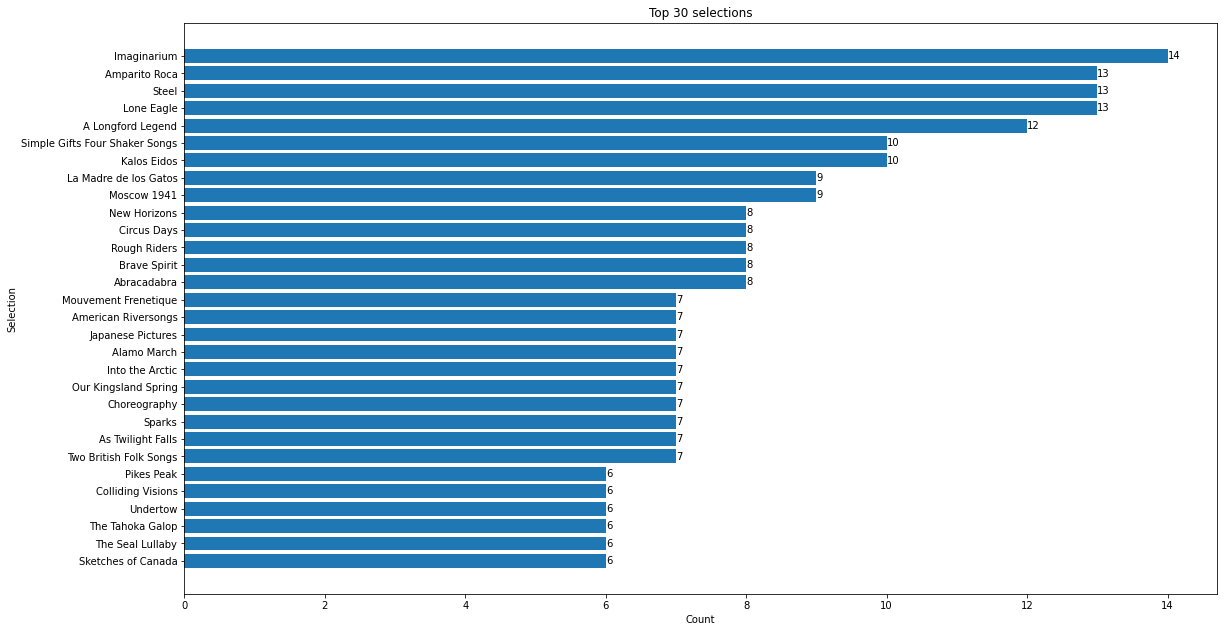

In [10]:

# Plot top n selections
def plotter(n=20, d=df, y=year_list, cl=class_list, co=conf_list):
    fig, ax = plt.subplots()
    bars = ax.barh(top_n_grabber(n, d, y, cl, co)[0], top_n_grabber(n, d, y, cl, co)[1])
    ax.set_title(f'Top {n} selections')
    ax.set_xlabel('Count')
    ax.set_ylabel('Selection')
    for bars in ax.containers:
        ax.bar_label(bars)
    # invert the y-axis
    ax.invert_yaxis()
   # reset size of the plot
    fig.set_size_inches(18.5, 10.5)

    plt.show()

plotter(30, df, [2022], ['Non-Varsity'], ['AAAAAA', 'AAAAA'])

# Find Rows by Selection Title

In [11]:
# Combine all rows where any selection contains the search term
def selection_finder(selection, d=df, y=year_list, cl=class_list, co=conf_list):
    df_grabber = d
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Year.to_list()).isin(y).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Classification.to_list()).isin(cl).any(1).values]
    df_grabber = df_grabber[pd.DataFrame(df_grabber.Conference.to_list()).isin(co).any(1).values]
    finder_df = df_grabber[(df_grabber['Selection 1'].str.contains(selection)) | (df_grabber['Selection 2'].str.contains(selection)) | (df_grabber['Selection 3'].str.contains(selection))]
    return finder_df

selection = 'Melody Shop'
year = [2022]
classification = class_list
conference = conf_list

selection_finder(selection, df, year, class_list, conf_list)

,Unnamed: 0,School,City,Directors,Conference,Classification,Year,ID,Stage Judge 1,Stage Judge 2,...,Stage Final,SR Judge 1,SR Judge 2,SR Judge 3,SR Final,Award,Selection 1,Selection 2,Selection 3,Stage Average
57152,60026,Pearland High School,Pearland,"Kenneth Brown / Gino Hernandez, Patricia Rhoa...",AAAAAA,Varsity,2022,178202,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,La Fiesta Mexicana,Traveler,The Melody Shop,1.000000
57446,60326,Azle High School,Azle,"Aaron Martin / Greg Davis, Michael Strange",AAAAA,Varsity,2022,176590,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,Festive Overture,Salvation is Created,The Melody Shop,1.000000
57463,60346,L.D. Bell High School,Hurst,"Suzanne Dell / Ben Maughmer, Chris Harmon, Mo...",AAAAAA,Varsity,2022,175565,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Second Suite for Band in F Major,Aurora Awakes,1.000000
58652,18639,Duncanville High School,Duncanville,Mark Teal,AAAAAA,Non-Varsity,2022,172291,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,C,Metamorphic Dances,Saturn Returns,The Melody Shop,1.000000
58762,54131,Lovejoy High School,Lucas,"Paul Heuer / Daniel King, Alex Holloway",AAAAA,Varsity,2022,177349,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Molly On The Shore,Finale,1.000000
58800,54094,Centennial High School,FRISCO,Andy Rein,AAAAA,Varsity,2022,175405,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Kingfishers Catchfire,Four Scottish Dances,1.000000
58827,54106,Prosper High School,Prosper,"Brandon Holt / Aaron Renzenbrink, Aaron Dugge...",AAAAAA,Varsity,2022,175896,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,March To The Scaffold,La Fiesta Mexicana,1.000000
59212,54520,Legacy High School,Mansfield,"Andrew Nance / Christopher Monasmith, Chris V...",AAAAA,Varsity,2022,176326,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Elsas Procession to the Cathedral,The Speed of Heat,1.000000
59324,54368,Lake Travis High School,Austin,"Richard Hicks / Taylor Trevino, Lance Brightw...",AAAAAA,Varsity,2022,176168,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Frozen Cathedral,Symphonie Fantastique - Dream of a Witches Sab...,1.000000
59698,53788,Foster High School,Richmond,"Erich Sonnier / Brian Allmond, Jeremiah Salis...",AAAAA,Varsity,2022,177627,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,A,The Melody Shop,Ride,Acadiana,1.000000


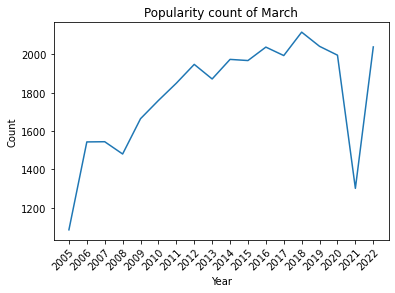

In [16]:
selection = 'March'
yearly_count_values = []
selection_finder_df = df


for y in year_list:
    selection_finder_df = selection_finder(selection, df, [y], class_list, conf_list)
    yearly_count_values.append(len(selection_finder_df))

# make a line graph of the yearly count of selections
def yearly_count_plotter(yearly_count_values):
    fig, ax = plt.subplots()
    ax.plot(yearly_count_values)
    ax.set_title(f'Popularity count of {selection}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    # set number of ticks on x-axis to match len(year_list)
    ax.set_xticks(range(len(year_list)))
    # set x labels to year_list
    ax.set_xticklabels(year_list)
    # rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

yearly_count_plotter(yearly_count_values)

# Find Rows by Directors

In [13]:
def director_finder(director, df):
    finder_df = df[df['Directors'].str.contains(director)]
    return finder_df

director = 'Kevin MacDonald'
df_for_search = df

director_finder_df = director_finder(director, df_for_search)
director_finder_df.sort_values(by='Stage Average', ascending=False)

,Unnamed: 0,School,City,Directors,Conference,Classification,Year,ID,Stage Judge 1,Stage Judge 2,...,Stage Final,SR Judge 1,SR Judge 2,SR Judge 3,SR Final,Award,Selection 1,Selection 2,Selection 3,Stage Average
48568,27144,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity B,2019,150128,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,,Miss Liberty,Knights of Dunvegan,La Madre de los Gatos,2.333333
47958,25830,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2019,150131,2.0,2.0,...,2.0,1.0,1.0,2.0,1.0,2,Rough Riders,Gigue Francaise,Chanteys,2.333333
47551,51083,Sachse HS Band,Sachse,"Holly Taylor / Kevin MacDonald, John Robinson",AAAAAA,Varsity,2019,148887,2.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1,Rolling Thunder March,Divertimento for Winds and Percussion,Danzon No 2,1.666667
59895,27283,Sachse High School,Garland,"Garrett Tucker / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity B,2022,177206,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,,Valley Forge March,Japanese Pictures,Flight of Eagles,1.666667
49425,12803,Sachse High School,Garland,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2019,150018,2.0,1.0,...,2.0,1.0,2.0,1.0,1.0,2,Sol Y Sombra,The Fire of Eternal Glory,Light Cavalry,1.666667
41759,25619,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2017,127766,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,,Big Four March,The Lowlands of Scotland,La Bonne Aventure,1.666667
45849,27078,Sachse HS Band,Sachse,Holly Taylor / Kevin MacDonald and John Robinson,AAAAAA,Sub Non-Varsity B,2018,138766,1.0,1.0,...,1.0,3.0,2.0,3.0,3.0,2,Omaha Beach Concert March,Legend of Knife River,Sketches of Canada,1.333333
34815,25507,Sachse High School,Sachse,"John Robinson / Holly Taylor, Kevin MacDonald",AAAAAA,Sub Non-Varsity A,2016,116448,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,C,The Big Cage,Blue Ridge Saga,La Madre de los Gatos,1.333333
39974,10741,Sachse HS Band,Sachse,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2017,127750,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,C,American Folk Rhapsody No 2,Redemption,Americans We,1.333333
37940,9821,Sachse HS Band,Sachse,Kevin MacDonald / Holly Taylor/John Robinson,AAAAAA,Non-Varsity,2016,116449,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,C,Men of Ohio,Fantasy on a Theme by Samual Barber,Choreography,1.333333


In [14]:
director_score = director_finder_df['Stage Average'].mean()
director_score

1.3174603174603174